## Dati Satellite Sentinel-1 (SAR bands)

In [1]:
from path import Path
import arrow
import json
import pytz
import time
from pprint import pprint
from tqdm.notebook import tqdm
import re, os, collections, itertools, uuid, logging
import tempfile

import zipfile
import urllib

import ee
import pyproj
import numpy as np
import scipy as sp
import pandas as pd
import geopandas as gpd
from matplotlib import pyplot as plt
import seaborn as sns
import shapely

plt.rcParams['figure.figsize'] = (15, 5) # bigger plots
plt.style.use('fivethirtyeight')
%matplotlib inline
%precision 4

'%.4f'

In [2]:
helper_dir = str(Path('..').abspath())
if helper_dir not in os.sys.path:
    os.sys.path.append(helper_dir)
    
from leak_helpers.earth_engine import display_ee, get_boundary, tifs2np, bands_s1, download_image, bands_s2, bands_l7, bands_l8
from leak_helpers.visualization import imshow_bands

In [3]:
# # Non voglio stampare i Warning
# import warnings
# warnings.filterwarnings("ignore")

# Load leaks

Load the leaks from a geojson file and make sure they have unique fields REPO_Date and workorderid (see asserts below)

In [3]:
# load 
root = "../../../ricerca_perdite"
leaks = gpd.read_file(root+"/data/leak_dataset/leaks.geojson")

leaks_datas = [leaks]

leaks_datas

[         id  anno civico      comune  comune_loc  \
 0         0  2015      0   PODENZANA   PODENZANA   
 1         1  2015      1     TRESANA     TRESANA   
 2         3  2015     00  pontremoli  PONTREMOLI   
 3         9  2016         pontremoli  PONTREMOLI   
 4        44  2021   None  PONTREMOLI  PONTREMOLI   
 ...     ...   ...    ...         ...         ...   
 1708  34754  2021     51    CAMAIORE    CAMAIORE   
 1709  34760  2021   None    CAMAIORE    CAMAIORE   
 1710  34873  2021   None   MASSAROSA   MASSAROSA   
 1711  34881  2021     24  FILATTIERA  FILATTIERA   
 1712  35025  2022   None   MASSAROSA   MASSAROSA   
 
                                             description  diametro  \
 0       Perdita acqua dalla rete montedivalli podenzana     110.0   
 1     perdita su adduttrice serbatoio giovagallo ese...      90.0   
 2       rotture idriche addutrice serbatoio di s. marco     125.0   
 3                                      PERDITA STRADALE     110.0   
 4     Manca

In [4]:
# join them all, with primary columns and random metadata
primary_cols = ['workorderid','reportdate','geometry']
leaks = gpd.GeoDataFrame(pd.concat([leaks_data[primary_cols] for leaks_data in leaks_datas]), crs="EPSG:4326")
leaks['metadata'] = np.concatenate([leaks_data.drop(primary_cols,1).to_dict('records') for leaks_data in leaks_datas])
leaks.index = leaks.workorderid
leaks

C:\Users\TRANFA~1.CAR\AppData\Local\Temp/ipykernel_14044/2551425569.py:4: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  leaks['metadata'] = np.concatenate([leaks_data.drop(primary_cols,1).to_dict('records') for leaks_data in leaks_datas])


,workorderid,reportdate,geometry,metadata
workorderid,,,,
434549,434549,2015-05-15T16:14:00+00:00,POINT (9.85871 44.19513),"{'id': '0', 'anno': 2015, 'civico': '0', 'comu..."
449895,449895,2015-05-30T17:14:00+00:00,POINT (9.87618 44.23608),"{'id': '1', 'anno': 2015, 'civico': '1', 'comu..."
526117,526117,2015-09-08T06:34:01.403000+00:00,POINT (9.84730 44.38188),"{'id': '3', 'anno': 2015, 'civico': '00', 'com..."
815762,815762,2016-09-05T11:59:11.637000+00:00,POINT (9.86374 44.36673),"{'id': '9', 'anno': 2016, 'civico': '', 'comun..."
2621776,2621776,2021-07-17T05:44:00+00:00,POINT (9.84420 44.38554),"{'id': '44', 'anno': 2021, 'civico': None, 'co..."
...,...,...,...,...
2621532,2621532,2021-07-16T05:40:11.870000+00:00,POINT (10.30386 43.93762),"{'id': '34754', 'anno': 2021, 'civico': '51', ..."
2626643,2626643,2021-07-19T04:50:00+00:00,POINT (10.30334 43.94759),"{'id': '34760', 'anno': 2021, 'civico': None, ..."
2674832,2674832,2021-09-04T15:13:31.657000+00:00,POINT (10.29917 43.88345),"{'id': '34873', 'anno': 2021, 'civico': None, ..."


In [5]:
# limit leaks to the time and space where satellite data exists
print('before',len(leaks))

# limit it to after satelite came into service
leaks= leaks[pd.to_datetime(leaks.reportdate)>pd.Timestamp('2014-10-03', tz='UTC')] 

# # also limit them by location
# satellite_bounds = shapely.geometry.box(
#     # continentental us
#     minx = -124.7844079, # west long
#     miny =  24.7433195, # south lat
#     maxx = -66.9513812, # east long
#     maxy = 49.3457868, # north lat   
# )
# leaks = leaks[leaks.intersects(satellite_bounds)]
print('after',len(leaks))

before 1713
after 1713


## Params

Customise the values in the cell below

In [6]:
# params
bands = bands_s1 # list of satelite band names from earth engine
satellite = 'COPERNICUS/S1_GRD' # satelite name from earth engine
resolution_min = 10.0 # the lowest resolution on earth engine

# how many pixels hight and wide you image will be (centered on leak), should be odd, e.g. 25
pixel_length = 25.0

# you need to tweak this until you pass the "Test the distance need to get your rectangle" cell
fudge_distance_factor = -0.50

## Init

In [7]:
%%javascript
var kernel = IPython.notebook.kernel;
var thename = window.document.getElementById("notebook_name").innerHTML;
var command = "notebook_name = " + "'"+thename+"'";
kernel.execute(command);

<IPython.core.display.Javascript object>

In [8]:
notebook_name

'scraping_earth_engine_s1'

In [16]:
# constant params, probobly don't change
#time_bin_delta = 60*60*6 # how long before a leak to look (in seconds)
time_before_report = 5*24*60*60
time_after_report = 1*24*60*60
time_after_repair = 30*24*60*60
crs_grid = 3857 # keep this as auxilary sphere, this is the CRS the downloaded images will be in

# init
## init directories
ts=arrow.utcnow().format('YYYYMMDD-HH-mm-ss')
temp_dir = Path(root+'/data/scraped_satellite_images/'+satellite.replace("/","_")+'/tmp/')
output_dir = Path(root+'/data/scraped_satellite_images/'+satellite.replace("/","_"))
cache_dir = Path(output_dir+'/cache')
output_dir.makedirs_p()
temp_dir.makedirs_p()
cache_dir.makedirs_p()

## init logger
logger = logging.getLogger(notebook_name)
# logger.setLevel(logging.WARN)

temp_dir, output_dir, cache_dir

(Path('../../../ricerca_perdite/data/scraped_satellite_images/COPERNICUS_S1_GRD/tmp/'),
 Path('../../../ricerca_perdite/data/scraped_satellite_images/COPERNICUS_S1_GRD'),
 Path('../../../ricerca_perdite/data/scraped_satellite_images/COPERNICUS_S1_GRD/cache'))

In [10]:
# # record cofig in a json file
# metadata = dict(
#     notebook_name=notebook_name,
#     satellite=satellite,
#     #time_bin_delta=time_bin_delta,
#     time_before=time_before,
#     time_after=time_after,
#     pixel_length=pixel_length,
#     resolution_min=resolution_min,
#     bands=bands,
#     ts=ts,
#     crs_grid=crs_grid,
#     cache_dir=str(cache_dir),
#     temp_dir=str(temp_dir),
#     output_dir=str(output_dir),
# )
# metadata_file = output_dir.joinpath('script_metadata.json')
# json.dump(metadata, open(metadata_file,'w'))

# Earth Engine

In [12]:
# test earth-engine setup
from oauth2client import crypt # should have not error
import ee
ee.Initialize() # should give no errors, if so follow instructions

# test
image = ee.Image(ee.ImageCollection(satellite).first())
info = image.getInfo()
info

{'type': 'Image',
 'bands': [{'id': 'HH',
   'data_type': {'type': 'PixelType', 'precision': 'double'},
   'dimensions': [28690, 24380],
   'crs': 'EPSG:32649',
   'crs_transform': [25, 0, 121126.5406, 0, -25, 9304939.2309]},
  {'id': 'HV',
   'data_type': {'type': 'PixelType', 'precision': 'double'},
   'dimensions': [28690, 24380],
   'crs': 'EPSG:32649',
   'crs_transform': [25, 0, 121126.5406, 0, -25, 9304939.2309]},
  {'id': 'angle',
   'data_type': {'type': 'PixelType', 'precision': 'float'},
   'dimensions': [21, 23],
   'crs': 'EPSG:32649',
   'crs_transform': [-17767.3274,
    -10569.5338,
    751271.4878,
    10727.6023,
    -17439.3233,
    9066467.5081]}],
 'id': 'COPERNICUS/S1_GRD/S1A_EW_GRDH_1SDH_20141003T003636_20141003T003740_002658_002F54_ECFA',
 'version': 1649664854737010.0000,
 'properties': {'GRD_Post_Processing_start': 1412307793280,
  'sliceNumber': 1,
  'GRD_Post_Processing_facility_name': 'ESRIN headquarters',
  'resolution': 'H',
  'SLC_Processing_facility_nam

In [15]:
# orbit_numb = image.getInfo()["properties"]["relativeOrbitNumber_start"]
# orbit_prop = image.getInfo()["properties"]["orbitProperties_pass"]

# orbit_numb, orbit_prop

# Fetching images

For each point
- find the nearest image before the repair
- and the soonest image after repair
- save a part of each with metadata

Later will can filter, interpolate, read into numpy arrays, and save to hdf file

In [13]:
import dataset
cache_file = 'sqlite:///{}'.format(cache_dir.dirname().joinpath('cache.db'))
db = dataset.connect(cache_file)
cache_table = db.get_table('cached_ids', primary_id='workorderid')

def get_cached_ids():
    return set(row['workorderid'] for row in cache_table.distinct('workorderid'))

def init_cache(workorderid):
    """We will cache downloads in folders like 'id_after'"""
    if workorderid:
        try:
            cache_table.insert(dict(workorderid=workorderid))
        except:
            db.rollback()
        else:
            db.commit()
    return

#Aggiunge il workorderid per il quale ho già l'immagine della tabella
img_path = Path('../../data/scraped_satellite_images/'+satellite.replace("/","_")+'/cache/')
for i in os.listdir(img_path):
    init_cache(i.split('_')[0])

# Conta il set di workorderid già scaricati
print("Perdite già provate a scaricare:",len(get_cached_ids()))

Perdite già provate a scaricare: 0


In [14]:
# # Cancella dati dalla tabella
# cache_table.delete()

# Conta il set di workorderid che mancano da provare a scaricare
leak_to_scrape = set(leaks.workorderid).difference(set(get_cached_ids()))

print("Perdite mancanti da provare a scaricare:",len(leak_to_scrape))

Perdite mancanti da provare a scaricare: 1713


### Test the distance need to get your rectangle

Here we need to tweak `fudge_distance_factor` so that we get the image size of our choice. Start with zero and try -1, -0.5, -.25,0,0.25,0.5,0.75. This is to deal with rounding, projecting between CRS's etc. Don't worry the asserts below will yet you know when it's right.

Occasionaly the problem might be that the leak is at the edge of the image, giving a cropped image. Ignore these rare cases.

In [15]:
distance = resolution_min*(pixel_length/2.0+fudge_distance_factor)
distance

120.0000

In [17]:
import time
import traceback

cached_ids = get_cached_ids()


def get_image_for_leak(i, cached_ids=cached_ids):
    leak = leaks.loc[[i]]
    reportdate = arrow.get(leak.reportdate.values[0]).timestamp()
    
    # crappy way of recording that we tried this one
    workorderid = leak.workorderid.values[0]
    if workorderid in cached_ids:
        logger.info('Skipping cached download for leak id %s ',workorderid)
        return
    
    boundary = get_boundary(leak, distance=distance)
    
    # get image before    
    sentinel1_before = (ee.ImageCollection(satellite)
                        .filterBounds(boundary)
                        .filterDate((reportdate-time_before_report)*1000,(reportdate+time_after_report)*1000)
                        .filter(ee.Filter.eq('relativeOrbitNumber_start', 168)) # Prendo l'orbita 168
                        .sort('system:time_start', opt_ascending=False) ) # first will be latest
    
    results = sentinel1_before.size().getInfo()
    if results<1:
        logger.info('Error no results for day before %s',workorderid)
        cached_ids = init_cache(str(workorderid)) # so we know there where no results
        return
    
    orbit_numb = ee.Image(sentinel1_before.first()).getInfo()["properties"]["relativeOrbitNumber_start"]
    orbit_prop = ee.Image(sentinel1_before.first()).getInfo()["properties"]["orbitProperties_pass"]
        
    # get image after the leak was repaired
    sentinel1_after = (ee.ImageCollection(satellite)
                       .filterBounds(boundary)
                       .filterDate((reportdate+time_after_repair)*1000,(reportdate+time_after_repair*2)*1000)
                       .filter(ee.Filter.eq('orbitProperties_pass', orbit_prop))
                       .filter(ee.Filter.eq('relativeOrbitNumber_start', orbit_numb))
                       .sort('system:time_start', opt_ascending=True) ) # first will be earliest
        
    results = sentinel1_after.size().getInfo()
    if results<1:
        logger.info('Error no results after the leak was repaired, id %s',workorderid)
        cached_ids = init_cache(str(workorderid)) # so we know there where no results
        return
    
    # get a 2nd image after the leak was repaired
    sentinel1_after2 = (ee.ImageCollection(satellite)
                       .filterBounds(boundary)
                       .filterDate((reportdate+time_after_repair*2)*1000,(reportdate+time_after_repair*3)*1000)
                       .filter(ee.Filter.eq('orbitProperties_pass', orbit_prop))
                       .filter(ee.Filter.eq('relativeOrbitNumber_start', orbit_numb))
                       .sort('system:time_start', opt_ascending=True) ) # first will be earliest
        
    results = sentinel1_after2.size().getInfo()
    if results<1:
        logger.info('Error no results for the 2nd image after the leak was reaired, id %s',workorderid)
        cached_ids = init_cache(str(workorderid)) # so we know there where no results
        return
        
    # download as save images    
    logger.info('results for %s', workorderid)
    image = ee.Image(sentinel1_before.first()).clip(boundary)
    name=str(workorderid)+'_before'
    path,files=download_image(
        image, 
        scale=resolution_min, 
        crs=crs_grid, 
        name=name,
        cache_dir=cache_dir
    )
    # also save metadata so we can filter by date
    with open(path.joinpath('metadata.json'), 'w') as fo:
        metadata = dict(
            image=image.getInfo(),
            scale=resolution_min,
            crs=crs_grid,
            name=name,
            distance=distance,
            leak=json.loads(leak.to_json())
        )
        json.dump(metadata, fo)

    image = ee.Image(sentinel1_after.first()).clip(boundary)
    name=str(workorderid)+'_after'
    path,files=download_image(
        image, 
        scale=resolution_min, 
        crs=crs_grid, 
        name=name,
        cache_dir=cache_dir
    )
    with open(path.joinpath('metadata.json'), 'w') as fo:
        metadata = dict(
            image=image.getInfo(),
            scale=resolution_min,
            crs=crs_grid,
            name=name,
            distance=distance,
            leak=json.loads(leak.to_json())
        )
        json.dump(metadata, fo)
    
    image = ee.Image(sentinel1_after2.first()).clip(boundary)
    name=str(workorderid)+'_after2'
    path,files=download_image(
        image, 
        scale=resolution_min, 
        crs=crs_grid, 
        name=name,
        cache_dir=cache_dir
    )
    with open(path.joinpath('metadata.json'), 'w') as fo:
        metadata = dict(
            image=image.getInfo(),
            scale=resolution_min,
            crs=crs_grid,
            name=name,
            distance=distance,
            leak=json.loads(leak.to_json())
        )
        json.dump(metadata, fo)
    
    cached_ids = init_cache(str(workorderid)) # so we know there where no results
        
    return

leak_to_scrape = set(leaks.workorderid).difference(set(cached_ids))
for i in tqdm(leak_to_scrape):
    try:
        get_image_for_leak(i)
    except urllib.error.HTTPError as e:
        print(i,e) # "HTTP Error 429: unknown"
        traceback.print_stack()
        if e.code == 429:
            print('sleep for 13s')
            time.sleep(13);
    except ee.ee_exception.EEException as e:
        print(i,e) # "Earth Engine memory capacity exceeded."
        traceback.print_stack()
        ee.Initialize()
    except zipfile.BadZipFile as e:
        print(i,e) # "File is not a zip file"
        traceback.print_stack()
    except Exception as e:
        print(i,e)
        traceback.print_stack()

  0%|          | 0/1713 [00:00<?, ?it/s]

# Load Tiffs to Arrays

When there are errors, e.g. no metadata.json is directory, delete the directory and go back to the scraping step

TODO automate the directory deletion

In [20]:
# This loads it as X and y for machine learning, and also time and metadata so we can filter
X = []
y = []
t = []
m = []
discarded=[]
cdirs = [cdir for cdir in cache_dir.listdir() if ('_after_' in cdir) or ('_before_' in cdir)]

for path in tqdm(cdirs):
    files = [file.relpath(path) for file in path.listdir() if file.endswith('.tif')]
    if files:
        # check metadata
        try:
            metadata = json.load(open(path.joinpath('metadata.json')))
        except (FileNotFoundError, ValueError) as e:
            path.move(path.dirname().dirname().joinpath('.deleteme-'+str(uuid.uuid4())))
            if '_after_' in path: # also delete the before path
                path_after = Path(path.replace('_after_','_before_'))
                if path_after.isdir():
                    path_after.move(path.dirname().dirname().joinpath('.deleteme-'+str(uuid.uuid4())))
            logger.error('Invalid metadata.json, deleted folder %s, please rerun scraping cell to rescrape this image', path)
            continue
        
        # e.g. lets filter it so "before" image are only 1 day before
        if '_before_' in path.basename():
            yy = True
        else:
            yy = False
        
        # work out time gap too
        t1 = arrow.get(metadata['image']['properties']['system:time_start']/1000)
        t0 = arrow.get(metadata['leak']['features'][0]['properties']['reportdate'])
        td=t1-t0
        tt = td.total_seconds()
        
        # load data
        data = tifs2np(path,files,bands=bands)
        #data = np.asarray(data1, order="C", dtype=object)
             
        # check we don't have empty bands
        empty_bands = np.array([d.sum() for d in data])==0
        
        # lets check we didn't get the edge of an image
        bbox = np.array(metadata['image']['properties']['system:footprint']['coordinates'][0])
        loc = metadata['leak']['features'][0]['geometry']['coordinates']
        minx=bbox[:,0].min()
        maxx=bbox[:,0].max()
        miny=bbox[:,1].min()
        maxy=bbox[:,1].max()
        bbox_shp = shapely.geometry.box(
            minx=minx,
            maxx=maxx,
            miny=miny,
            maxy=maxy
        )
        loc_shp = shapely.geometry.Point(loc[0],loc[1])
        shapely.geometry.GeometryCollection([bbox_shp, loc_shp])
        try:
            assert loc_shp.intersects(bbox_shp), 'leak location should be inside image'
            assert bbox_shp.centroid.almost_equals(loc_shp, decimal=5), 'leak should be near center of image'
            assert (np.array([d.shape for d in data])==pixel_length).all(), 'image area should be the right amount of pixels'
            #assert (maxx-minx)/(maxy-miny)<1.3, 'should be roughly square' #tolto l'assert 19/11/21 perchè buttava via tutte le imamgini
            #assert (maxx-minx)/(maxy-miny)>0.7, 'should be roughly square' #tolto l'assert 19/11/21 perchè buttava via tutte le imamgini
            assert not empty_bands.all(), 'should not have all bands empty'
            ##assert metadata['image']['properties']["relativeOrbitNumber_start"] == 168, 'la foto deve avere Orbita numero 168' # assert temporaneo poichè il numero di orbita conta molto
            ##assert metadata['image']['properties']["orbitProperties_pass"] == 'DESCENDING', 'la foto deve essere stata scattata con orbita DESCENDING' # assert temporaneo poichè il tipo di acquisizione conta
        except Exception as exc:
            print(path, exc)
            discarded.append(path)
        else:
            X.append(data)
            y.append(yy)
            t.append(tt)
            m.append(metadata)

len(X), len(discarded)

  0%|          | 0/2568 [00:00<?, ?it/s]

C:\Users\TRANFA~1.CAR\AppData\Local\Temp/ipykernel_14044/1312473541.py:60: ShapelyDeprecationWarning: The 'almost_equals()' method is deprecated and will be removed in Shapely 2.0
  assert bbox_shp.centroid.almost_equals(loc_shp, decimal=5), 'leak should be near center of image'


(2568, 0)

In [21]:
# record cofig in a json file
metadata = dict(
    notebook_name=notebook_name,
    satellite=satellite,
    time_before_report=time_before_report,
    time_after_report=time_after_report,
    time_after_repair=time_after_repair,
    pixel_length=pixel_length,
    resolution_min=resolution_min,
    bands=bands,
    ts=ts,
    crs_grid=crs_grid,
    cache_dir=str(cache_dir),
    temp_dir=str(temp_dir),
    output_dir=str(output_dir),
)
metadata_file = output_dir.joinpath('script_metadata.json')
json.dump(metadata, open(metadata_file,'w'))

bands

['VV', 'VH', 'angle']

In [21]:
# ### Nuova parte per creare i dataset delle differenze prima e dopo la perdita
# cached_ids = get_cached_ids()

# X = []
# y = []
# m = []
# t = []
# discarded=[]

# for leak in tqdm(cached_ids):
#     leak = str(leak)
#     X_leak = np.zeros(shape=(5,25,25))
#     X_noleak = np.zeros(shape=(5,25,25))
#     metadata_leak = {}
#     metadata_noleak = {}
#     img_number = 0
#     cdirs = [ cache_dir+'/'+leak+'_after2_3857_10.0', 
#              cache_dir+'/'+leak+'_after_3857_10.0', 
#              cache_dir+'/'+leak+'_before_3857_10.0' ]
#     #print(leak, cdirs)
#     for path in cdirs:
#         if path.exists():
#             files = [file.relpath(path) for file in path.listdir() if file.endswith('.tif')]
#             #print(leak, files)
#             if files:
#                 # check metadata
#                 try:
#                     metadata = json.load(open(path.joinpath('metadata.json')))
#                 except (FileNotFoundError, ValueError) as e:
#                     path.move(path.dirname().dirname().joinpath('.deleteme-'+str(uuid.uuid4())))
#                     if '_after_' in path: # also delete the before path
#                         path_after = Path(path.replace('_after_','_before_'))
#                         if path_after.isdir():
#                             path_after.move(path.dirname().dirname().joinpath('.deleteme-'+str(uuid.uuid4())))
#                     if '_after2_' in path: # also delete the before path
#                         path_after2 = Path(path.replace('_after2_','_before_'))
#                         if path_after2.isdir():
#                             path_after2.move(path.dirname().dirname().joinpath('.deleteme-'+str(uuid.uuid4())))   
#                     logger.error('Invalid metadata.json, deleted folder %s, please rerun scraping cell to rescrape this image', path)
#                     continue

#                 # load data
#                 data = tifs2np(path,files,bands=bands)

#                 # check we don't have empty bands
#                 empty_bands = np.array([d.sum() for d in data])==0

#                 # lets check we didn't get the edge of an image
#                 bbox = np.array(metadata['image']['properties']['system:footprint']['coordinates'][0])
#                 loc = metadata['leak']['features'][0]['geometry']['coordinates']
#                 minx=bbox[:,0].min()
#                 maxx=bbox[:,0].max()
#                 miny=bbox[:,1].min()
#                 maxy=bbox[:,1].max()
#                 bbox_shp = shapely.geometry.box(
#                     minx=minx,
#                     maxx=maxx,
#                     miny=miny,
#                     maxy=maxy
#                 )
#                 loc_shp = shapely.geometry.Point(loc[0],loc[1])
#                 shapely.geometry.GeometryCollection([bbox_shp, loc_shp])
#                 try:
#                     assert loc_shp.intersects(bbox_shp), 'leak location should be inside image'
#                     assert bbox_shp.centroid.almost_equals(loc_shp, decimal=5), 'leak should be near center of image'
#                     assert (np.array([d.shape for d in data])==pixel_length).all(), 'image area should be the right amount of pixels'
#                     assert not empty_bands.all(), 'should not have all bands empty'
#                     ##assert metadata['image']['properties']["relativeOrbitNumber_start"] == 168, 'la foto deve avere Orbita numero 168' # assert temporaneo poichè il numero di orbita conta molto
#                     ##assert metadata['image']['properties']["orbitProperties_pass"] == 'DESCENDING', 'la foto deve essere stata scattata con orbita DESCENDING' # assert temporaneo poichè il tipo di acquisizione conta
#                 except Exception as exc:
#                     print(path, exc)
#                     discarded.append(path)
#                 else:
#                     if '_before_' in path.basename():
#                         X_leak = X_leak + np.array(data)
#                         metadata_leak['before'] = metadata
#                         t_leak = arrow.get(metadata['image']['properties']['system:time_start']/1000).timestamp()
#                         img_number += 1
#                     elif '_after_' in path.basename():
#                         X_leak = X_leak - np.array(data)
#                         X_noleak = X_noleak - np.array(data)
#                         metadata_leak['after'] = metadata
#                         metadata_noleak['after'] = metadata
#                         img_number += 1
#                     elif '_after2_' in path.basename():
#                         X_noleak = X_noleak + np.array(data)
#                         metadata_noleak['after2'] = metadata
#                         t_noleak = arrow.get(metadata['image']['properties']['system:time_start']/1000).timestamp()
#                         img_number += 1
#     if img_number == 3 :
#         X.append(X_leak)
#         y.append(True)
#         m.append(metadata_leak)
#         t.append(int(t_leak))
#         X.append(X_noleak)
#         y.append(False)
#         m.append(metadata_noleak)
#         t.append(int(t_noleak))
#     else:
#         discarded.append(leak)

# len(X), len(discarded)

In [22]:
#### Grafico VV-VH
X_array = np.array(X)
dim = X_array.shape[0]*X_array.shape[2]*X_array.shape[3]

wonum = np.array([ [m[i]['leak']['features'][0]['properties']['metadata']['wonum']]*X_array.shape[2]*X_array.shape[3] for i in range(len(m)) ]).reshape(dim)
reportdate = np.array([ [m[i]['leak']['features'][0]['properties']['reportdate']]*X_array.shape[2]*X_array.shape[3] for i in range(len(m)) ]).reshape(dim)
VV = X_array[:,bands.index('VV')].reshape(dim)
VH = X_array[:,bands.index('VH')].reshape(dim)
angle = X_array[:,bands.index('angle')].reshape(dim)
leak = np.array([[y[i]]*X_array.shape[2]*X_array.shape[3] for i in range(len(y))]).reshape(dim)
metadata = np.array([ [m[i]]*X_array.shape[2]*X_array.shape[3] for i in range(len(m)) ]).reshape(dim)
orbit = np.array([ [ m[i]['image']['properties']["relativeOrbitNumber_start"]]*X_array.shape[2]*X_array.shape[3] for i in range(len(m)) ]).reshape(dim)

sar_array = np.array((wonum, reportdate, VV, VH, angle, leak, metadata, orbit)).T
data_sar = pd.DataFrame(sar_array, columns = ['wonum','reportdate','VV','VH','angle','leak','metadata','orbit'])

data_sar

,wonum,reportdate,VV,VH,angle,leak,metadata,orbit
0,17ODL168987,2017-02-27T09:20:59.196999+00:00,-8.548181,-12.329769,38.088978,False,"{'image': {'type': 'Image', 'bands': [{'id': '...",168
1,17ODL168987,2017-02-27T09:20:59.196999+00:00,-9.318793,-13.872254,38.088547,False,"{'image': {'type': 'Image', 'bands': [{'id': '...",168
2,17ODL168987,2017-02-27T09:20:59.196999+00:00,-9.418916,-14.663663,38.088116,False,"{'image': {'type': 'Image', 'bands': [{'id': '...",168
3,17ODL168987,2017-02-27T09:20:59.196999+00:00,-9.418916,-14.663663,38.087688,False,"{'image': {'type': 'Image', 'bands': [{'id': '...",168
4,17ODL168987,2017-02-27T09:20:59.196999+00:00,-10.86345,-17.402162,38.087257,False,"{'image': {'type': 'Image', 'bands': [{'id': '...",168
...,...,...,...,...,...,...,...,...
1604995,17ODL162945,2017-02-20T17:27:00+00:00,-11.170554,-16.142631,38.341316,True,"{'image': {'type': 'Image', 'bands': [{'id': '...",168
1604996,17ODL162945,2017-02-20T17:27:00+00:00,-9.700933,-13.974538,38.340889,True,"{'image': {'type': 'Image', 'bands': [{'id': '...",168
1604997,17ODL162945,2017-02-20T17:27:00+00:00,-9.700933,-13.974538,38.340462,True,"{'image': {'type': 'Image', 'bands': [{'id': '...",168
1604998,17ODL162945,2017-02-20T17:27:00+00:00,-11.301222,-14.274708,38.340034,True,"{'image': {'type': 'Image', 'bands': [{'id': '...",168


In [23]:
data_detail = []
for b in range(X_array.shape[1]):
    data_detail.append([bands[b],X_array[:,b].min(),X_array[:,b].max(), np.count_nonzero(X_array[:,b])])

data_detail = pd.DataFrame(data_detail, columns=["Banda","Min","Max","Non Zero"])
print(data_detail)

   Banda        Min        Max  Non Zero
0     VV -36.043572  35.034283   1603636
1     VH -47.707378  13.539669   1603636
2  angle  34.206566  39.647694   1605000


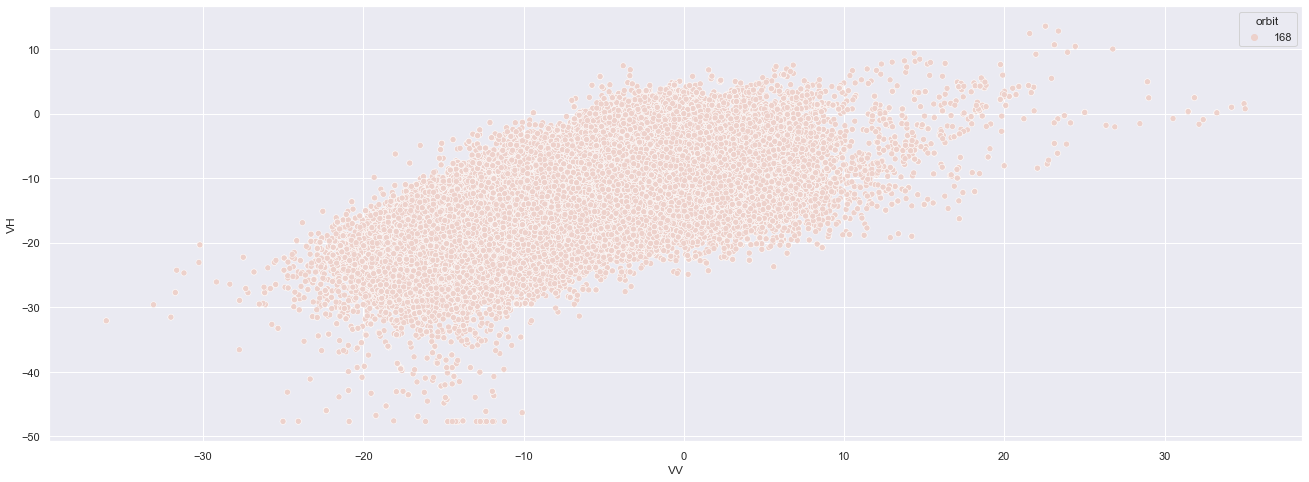

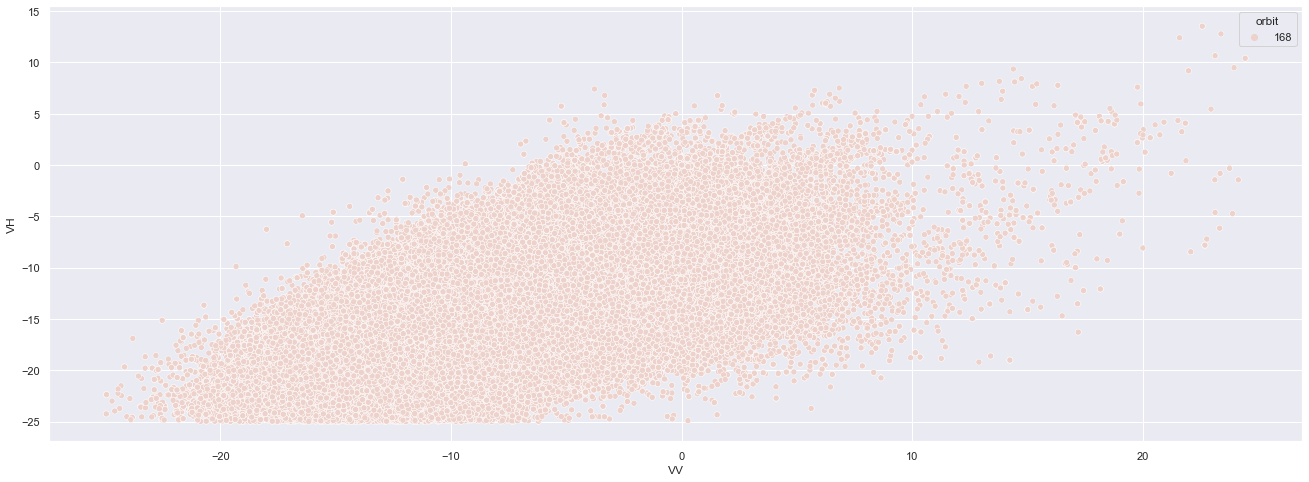

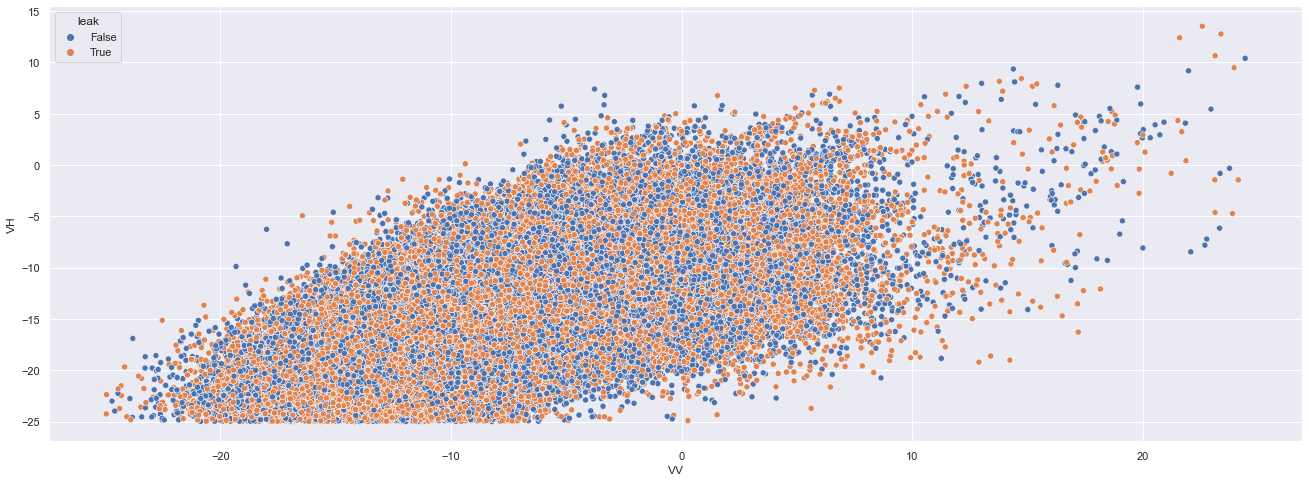

In [24]:
#### Grafico VV-VH
sns.set(rc={'figure.figsize':(20,8)})

data_plot = data_sar
#data_plot = data_sar.loc[data_sar['VV']>-25].loc[data_sar['VH']>-25].loc[data_sar['VV']<25].loc[data_sar['VH']<25]

sns.scatterplot(data=data_sar, x="VV", y="VH", hue="orbit")
plt.show()
#sns.scatterplot(data=data_plot, x="VV", y="VH", hue="orbit")
#plt.show()
sns.scatterplot(data=data_plot, x="VV", y="VH", hue="leak")
plt.show()

In [26]:
### Immagine random
import random
wo_id = random.randint(0, len(data_sar))
wonum = data_sar['wonum'].iloc[wo_id]
data = data_sar['reportdate'].iloc[wo_id]
print(wonum, data)

leak_vv = data_sar.loc[data_sar['wonum']==wonum].loc[data_sar['leak']==True]["VV"]
leak_vh = data_sar.loc[data_sar['wonum']==wonum].loc[data_sar['leak']==True]["VH"]
leak_angle = data_sar.loc[data_sar['wonum']==wonum].loc[data_sar['leak']==True]["angle"]
noleak_vv = data_sar.loc[data_sar['wonum']==wonum].loc[data_sar['leak']==False]["VV"]
noleak_vh = data_sar.loc[data_sar['wonum']==wonum].loc[data_sar['leak']==False]["VH"]
noleak_angle = data_sar.loc[data_sar['wonum']==wonum].loc[data_sar['leak']==False]["angle"]

leak_vv = np.array(leak_vv,dtype='float').reshape(25,25)
leak_vv_norm = (leak_vv-leak_vv.min())/(leak_vv.max()-leak_vv.min())
leak_vh = np.array(leak_vh,dtype='float').reshape(25,25)
leak_vh_norm = (leak_vh-leak_vh.min())/(leak_vh.max()-leak_vh.min())
leak_angle = np.array(leak_angle,dtype='float').reshape(25,25)
leak_angle_norm = (leak_angle-leak_angle.min())/(leak_angle.max()-leak_angle.min())

noleak_vv = np.array(noleak_vv,dtype='float').reshape(25,25)
noleak_vv_norm = (noleak_vv-noleak_vv.min())/(noleak_vv.max()-noleak_vv.min())
noleak_vh = np.array(noleak_vh,dtype='float').reshape(25,25)
noleak_vh_norm = (noleak_vh-noleak_vh.min())/(noleak_vh.max()-noleak_vh.min())
noleak_angle = np.array(noleak_angle,dtype='float').reshape(25,25)
noleak_angle_norm = (noleak_angle-noleak_angle.min())/(noleak_angle.max()-noleak_angle.min())

15ODL257958 2015-11-20T14:58:00+00:00


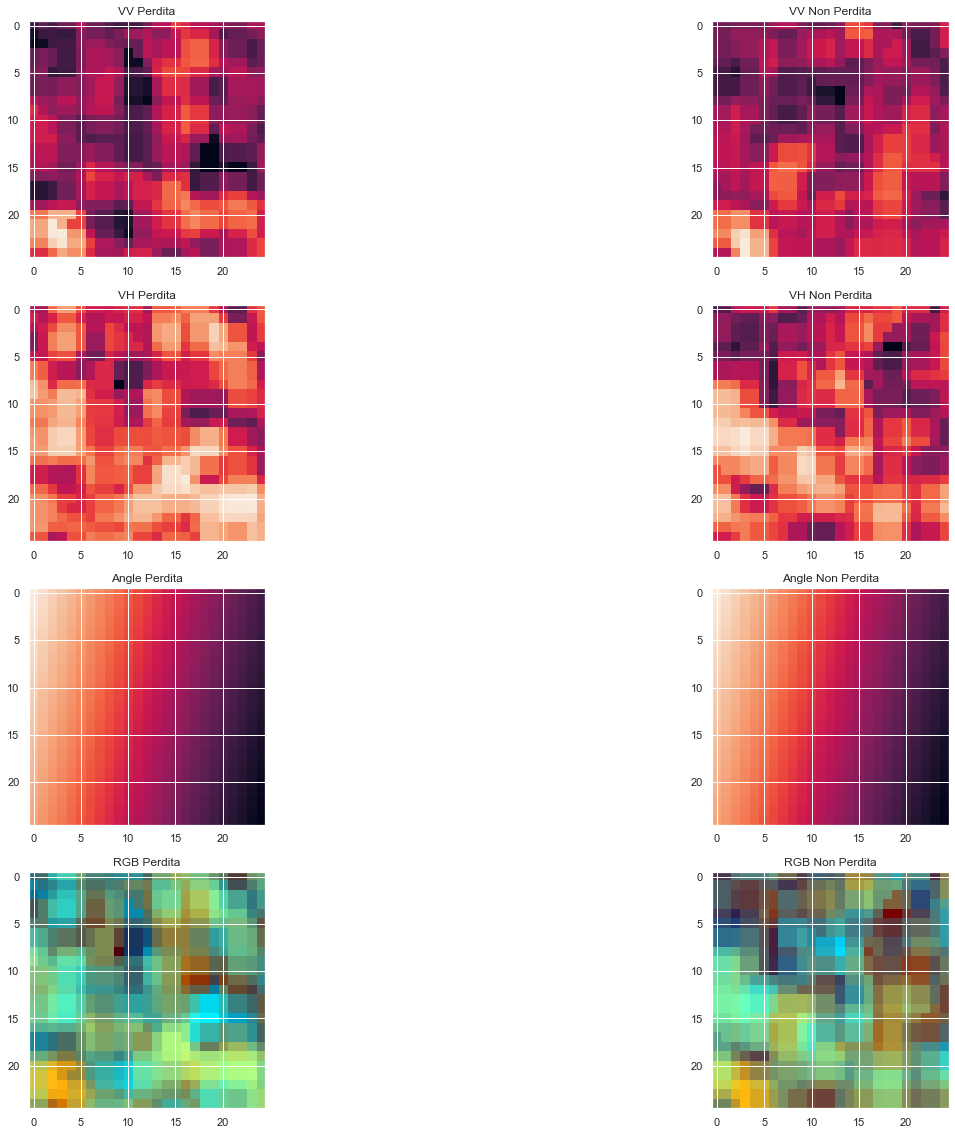

In [73]:
leak_vv_vh = leak_vh-leak_vv
leak_vv_vh_norm = (leak_vv_vh-leak_vv_vh.min())/(leak_vv_vh.max()-leak_vv_vh.min())
noleak_vv_vh = noleak_vh-noleak_vv
noleak_vv_vh_norm = (noleak_vv_vh-noleak_vv_vh.min())/(noleak_vv_vh.max()-noleak_vv_vh.min())


fig, axs = plt.subplots(4,2, figsize = (20,20))

axs[0,0].set_title("VV Perdita")
axs[0,0].imshow(leak_vv_norm)

axs[0,1].set_title("VV Non Perdita")
axs[0,1].imshow(noleak_vv_norm)

axs[1,0].set_title("VH Perdita")
axs[1,0].imshow(leak_vh_norm)

axs[1,1].set_title("VH Non Perdita")
axs[1,1].imshow(noleak_vh_norm)

axs[2,0].set_title("Angle Perdita")
axs[2,0].imshow(leak_angle_norm)

axs[2,1].set_title("Angle Non Perdita")
axs[2,1].imshow(noleak_angle_norm)

axs[3,0].set_title("RGB Perdita")
axs[3,0].imshow(np.stack((leak_vv_norm, leak_vh_norm, leak_vv_vh_norm), axis = -1))

axs[3,1].set_title("RGB Non Perdita")
axs[3,1].imshow(np.stack((noleak_vv_norm, noleak_vh_norm, noleak_vv_vh_norm), axis = -1))

In [24]:
# ### Check dell'obita di una perdita del gruppo oltre i -50
# test = data_sar.loc[data_sar['VV']<=-50].loc[data_sar['VH']<=-50]['metadata'].iloc[0]
# orbit_after = test['after']['image']['properties']['relativeOrbitNumber_start']
# orbit_before = test['before']['image']['properties']['relativeOrbitNumber_start']

# orbit_after, orbit_after2

In [74]:
# shuffle
from sklearn.utils import shuffle
X,y,m,t = shuffle(X,y,m,t,random_state=1337)

In [75]:
# save using hdf5 (so keras can easily load it) and json 
import h5py
h5file = output_dir.joinpath('data.h5')
with h5py.File(h5file, 'w') as h5f:
    h5f.create_dataset('X', data=X)
    h5f.create_dataset('y', data=y)
    h5f.create_dataset('t', data=t)

json.dump(m,open(output_dir.joinpath('data_metadata.json'),'w'))

with open(output_dir.joinpath('readme.md'),'w') as fo:
    fo. write("""
Files:
- cache- cached tiff files
- script_metadata.json - information on scraping script
- data.h5 contains X, y, and t.
    - X: tiff files for each band loaded into an array of shape (Leak, Bands, width, length)
    - y: True for before the leak, False for after
- data_metadata: array of metadata for each leak in X. Each contain info on leak, image, and image search
    
Loading: 
```py
# load
metadatas = json.load(open('data_metadata.json'))
with h5py.File('data.h5','r') as h5f:
    X2 = h5f['X'][:]
    y2 = h5f['y'][:]
    t2 = h5f['t'][:]
y
```
    """)

In [76]:
# test load
metadatas = json.load(open(output_dir.joinpath('data_metadata.json')))
with h5py.File(output_dir.joinpath('data.h5'),'r') as h5f:
    X2 = h5f['X'][:]
    y2 = h5f['y'][:]
    t2 = h5f['t'][:]
X2.shape, y2[:10], t2[:10], metadatas[0].keys()

((2568, 3, 25, 25),
 array([False,  True, False, False,  True,  True, False,  True, False,
        False]),
 array([3019488.4  , -173781.67 , 2937571.833, 3007241.   , -108517.   ,
         -17816.   , 2662994.833, -101312.   , 2927209.   , 2753451.   ]),
 dict_keys(['image', 'scale', 'crs', 'name', 'distance', 'leak']))

In [77]:
output_dir

Path('../../../ricerca_perdite/data/scraped_satellite_images/COPERNICUS_S1_GRD')